# Assignment 3

Matrikelnr.: 2089929

## Imports

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

## Überblick und Vorbereitung der Daten

In [152]:
df_social = pd.read_csv('03_Clustering_Marketing.csv',delimiter=';')
df_social.describe()

,gradyear,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2007.496933,29.834533,0.267000,0.255467,0.22200,0.159667,0.142933,0.135000,0.105133,0.104133,...,0.112867,0.259467,0.357267,0.150267,0.071800,0.051467,0.185867,0.118067,0.091733,0.061067
std,1.116516,35.386649,0.788851,0.702260,0.92042,0.737344,0.638747,0.548691,0.502491,0.519205,...,2.708619,0.704398,0.728512,0.478716,0.356258,0.280755,0.609928,0.455200,0.420631,0.349112
min,2006.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,20.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2008.000000,44.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2009.000000,605.000000,22.000000,9.000000,22.00000,17.000000,14.000000,31.000000,8.000000,14.000000,...,327.000000,12.000000,11.000000,8.000000,8.000000,8.000000,16.000000,14.000000,8.000000,16.000000


Der Datensatz umfasst 15.000 Zeilen und 40 Spalten. Er enthält eine Mischung aus numerischen und kategorialen Variablen, darunter das Abschlussjahr (gradyear), Geschlecht (gender), Alter (age), die Anzahl der Freunde (NumberOffriends) sowie eine Vielzahl von Angaben zu Interessen und Aktivitäten wie Basketball, Fußball, Schwimmen und persönliche Vorlieben wie Musik und Einkaufen.

Die Abschlussjahre im Datensatz reichen von 2006 bis 2009. Das Alter der Personen variiert, wobei einige Werte fehlen. Die Anzahl der Freunde pro Person reicht von 0 bis 605, mit einem Durchschnittswert von etwa 30 Freunden. Neben diesen demografischen Informationen enthält der Datensatz Angaben zu verschiedenen Aktivitäten und Vorlieben in Form von booleschen Werten.

### Datentypen berichtigen

In [153]:
df_social['age'] = pd.to_numeric(df_social['age'], errors='coerce')

### Nullwerte entfernen

In [154]:
df_social = df_social.dropna()

### Feature Extraction

<Axes: xlabel='age', ylabel='Count'>

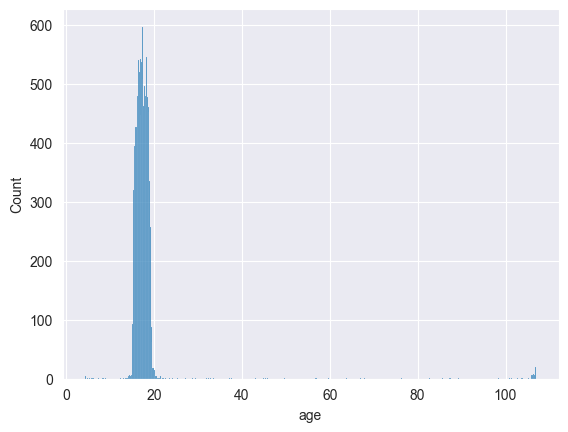

In [155]:
sns.histplot(df_social['age'])

Durch die Verwendung von float als Datentyp der Spalte Alter sehen wir extrem viele Dimensionen. Aus diesem Grund reduzieren wir die Dimensionen, indem wir Altersklassen definieren und in Bins zusammenfassen. Wir sehen außerdem eine Häufung im Altersbereich von 10 bis 20 Jahren. Deshalb definieren wir die Bins hier etwas feiner.

<Axes: xlabel='age', ylabel='Count'>

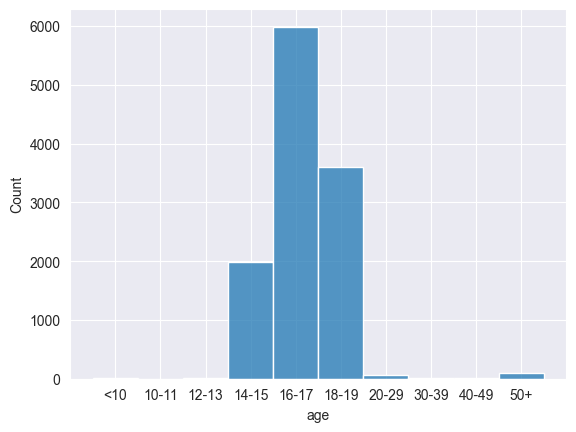

In [156]:
# Altersklassen definieren
bins = [0, 10, 12, 14, 16, 18, 20, 30, 40, 50, np.inf]
labels = ['<10', '10-11', '12-13', '14-15', '16-17', '18-19', '20-29', '30-39', '40-49', '50+']

# Bins erstellen
df_social['age'] = pd.cut(df_social['age'], bins=bins, labels=labels, right=False)
sns.histplot(df_social['age'])

<Axes: xlabel='NumberOffriends', ylabel='Count'>

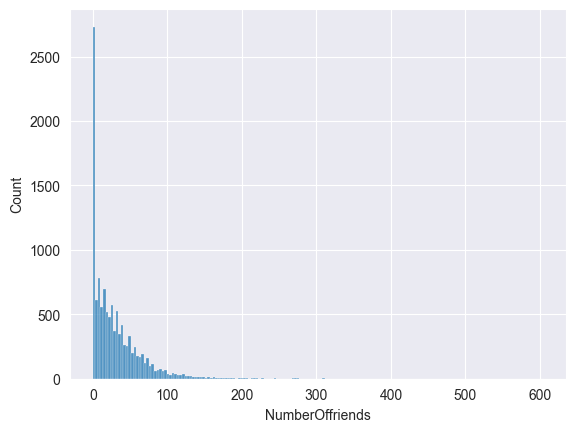

In [157]:
sns.histplot(df_social['NumberOffriends'])

Eine ähnliche Problematik sehen wir auch bei der Anzahl der Freunden, weshalb wir hier auch eine Dimensionsreduktion durchführen.

In [158]:
# Bins definieren für Anzahl an Freunden
bins_friends = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
labels_friends = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100','100+']

# Bins erstellen
#df_social['NumberOffriends'] = pd.cut(df_social['NumberOffriends'], bins=bins_friends, labels=labels_friends, right=False)

<Axes: xlabel='NumberOffriends', ylabel='Count'>

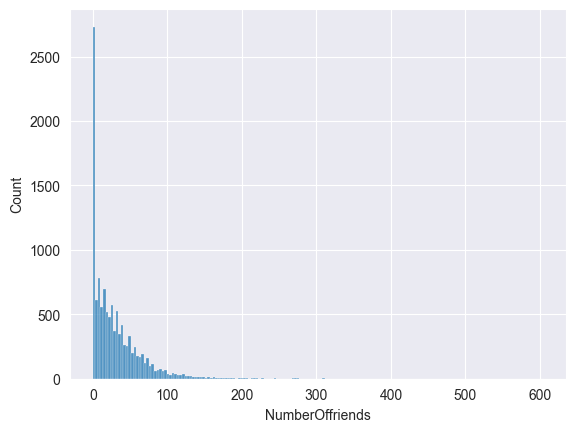

In [159]:
sns.histplot(df_social['NumberOffriends'])

### Prüfen von Ungleichgewichten

<Axes: xlabel='gender', ylabel='Count'>

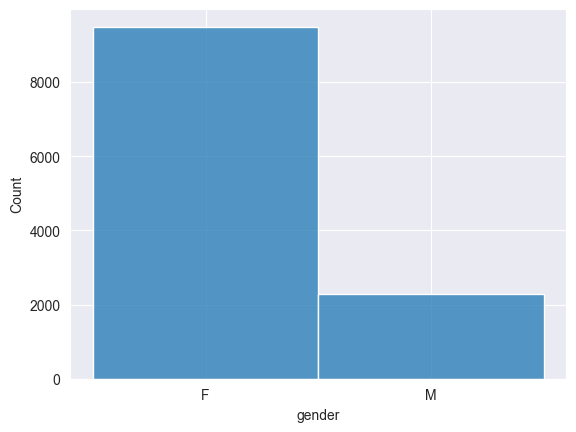

In [160]:
sns.histplot(df_social['gender'])

Wir sehen ein starkes Ungleichgewicht in Richtung des weiblichen Geschlechts, diesem werden wir uns später widmen.

In [161]:
# Dataframe aufteilen nach Geschlecht
df_social_m = df_social[df_social['gender'] == 'M']
df_social_f = df_social[df_social['gender'] == 'F']

# Die unterrepräsentierte Klasse identifizieren
undersample_size = min(len(df_social_m), len(df_social_f))

# Beide Dataframes nach der Größe der kleineren Klasse resamplen
df_social_m_under = df_social_m.sample(undersample_size, random_state=42)
df_social_f_under = df_social_f.sample(undersample_size, random_state=42)

# Beide Dataframes wieder kombinieren
df_social = pd.concat([df_social_m_under, df_social_f_under])

<Axes: xlabel='gender', ylabel='Count'>

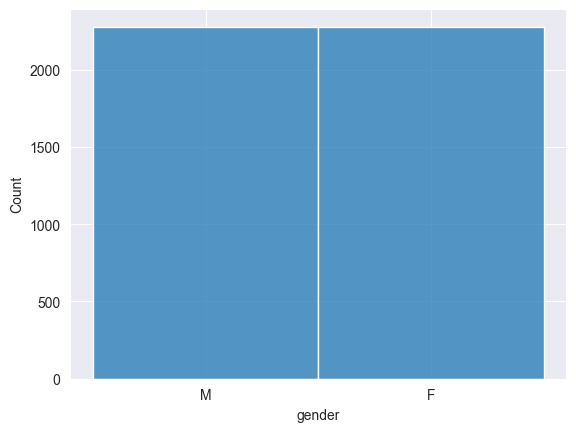

In [162]:
sns.histplot(df_social['gender'])

### Encoding

In [206]:
# Nicht-numerische Spalten identifizieren
non_numeric_columns = df_social.select_dtypes(include=['object', 'category']).columns

# Alle nicht-numerischen Spalten encoden
for col in non_numeric_columns:
    unique_values = df_social[col].unique()
    df_social[col] = df_social[col].replace(to_replace=unique_values, value=list(range(len(unique_values))))
    
df_social.head()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,hollister,abercrombie,die,death,drunk,drugs,test1,test2,Cluster_chache,cluster
2700,2008,0,0,88,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9093,2007,0,0,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12531,2009,0,0,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10337,2006,0,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,2,0,2,0
9518,2009,0,1,28,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,2,0


### Aufstellen der Cluster
Im nachfolgenden haben wir uns ein paar Cluster ausgesucht, die wir genauer betrachten möchten.

In [164]:
# Erstellen eines Standardskalierers
scaler = StandardScaler()

# Age vs number of friends
df_age_number_of_friends = scaler.fit_transform(df_social[['age', 'NumberOffriends']])
# Gender vs number of friends
df_gender_number_of_friends = scaler.fit_transform(df_social[['gender', 'NumberOffriends']])
# Age vs basketball
df_age_basketball = scaler.fit_transform(df_social[['age', 'basketball']])
# Age vs football
df_age_football = scaler.fit_transform(df_social[['age', 'football']])
# Age vs soccer
df_age_soccer = scaler.fit_transform(df_social[['age', 'soccer']])
# Age vs volleyball
df_age_volleyball = scaler.fit_transform(df_social[['age', 'volleyball']])
# Basketball vs football
df_basketball_football = scaler.fit_transform(df_social[['basketball', 'football']])
# Football vs cheerleading
df_football_cheerleading = scaler.fit_transform(df_social[['football', 'cheerleading']])

## Aufgabe 01
Cluster the existing data based on appropriate procedures. Justify how you would cluster the data set based on the results.

Zuerst führen wir die Ellenbogen und die Silhouette-Methode durch, um eine Idee für die Anzahl an Clustern zu bekommen. Um Code Zeilen zu sparen, definieren wir hierfür Funktionen.

In [184]:
# Diese Funktion dient der Visualisierung eines PairPlots
def createPairPlot(df_Imput, x_vars, y_vars, height_, k_clusters):
    kmeans_ = KMeans(n_clusters=k_clusters, random_state=42)
    y_pred = kmeans_.fit_predict(df_Imput)
    # Cluster speichern
    df_social['Cluster_chache'] = kmeans_.labels_
    scaler = StandardScaler()
    # Pairplot zur Visualisierung erstellen
    sns.pairplot(data=df_social, x_vars=[x_vars], y_vars=[y_vars], hue="Cluster_chache", height=height_ )
    
def createElbow(dataInput, breite, hoehe):
    df_norm = (dataInput - dataInput.mean()) / dataInput.std()

    # Initialisieren einer Liste zur Speicherung der SSD-Werte
    ssd = []

    # Berechnen der SSD für verschiedene Cluster-Größen
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df_norm)
        ssd.append(kmeans.inertia_)

    # Erstellen eines Diagramms, um den Ellbogen zu finden
    plt.figure(figsize=(breite, hoehe))
    plt.plot(range(1,10), ssd, 'bx-')
    plt.xlabel('Anzahl der Cluster (K)')
    plt.ylabel('Summe der quadrierten Abstände (SSD)')
    plt.title('Elbow-Methode')
    plt.show()
    
def silhouette_diagram(df, k_options):
    n_rows = len(k_options) // 2 + len(k_options) % 2
    plt.figure(figsize=(11, n_rows * 4.5))
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df) for k in range(1, max(k_options) + 1)]
    silhouette_scores = [silhouette_score(df, model.labels_) for model in kmeans_per_k[1:]]
    
    for i, k in enumerate(k_options, start=1):
        plt.subplot(n_rows, 2, i)
        
        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(df, y_pred)

        padding = len(df) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = mpl.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                            facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        if k in (3, 5):
            plt.ylabel("Cluster")
        
        if k in (5, 6):
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=False)

        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=16)

    plt.show()

Die Funktion wird nun auf unsere Cluster angewandt.

### Gender / Number of Friends

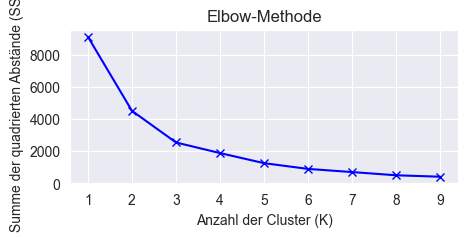

In [182]:
# Gender vs Anzahl der Freunde plotten
createElbow(df_gender_number_of_friends, 5, 2)

Der elbow plot zeigt eine optimale Clusterzahl von k=2.

### Age / Number of Friends

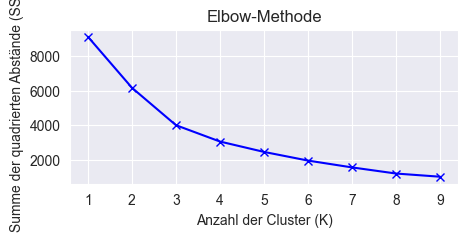

In [181]:
createElbow(df_age_number_of_friends, 5, 2)

Der elbow plot zeigt eine optimale Clusterzahl von k=3.

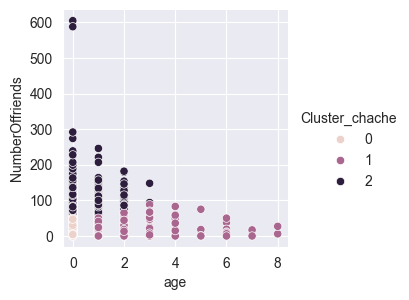

In [186]:
createPairPlot(df_age_number_of_friends, 'age', 'NumberOffriends', 3, 3)

### Basketball / Football

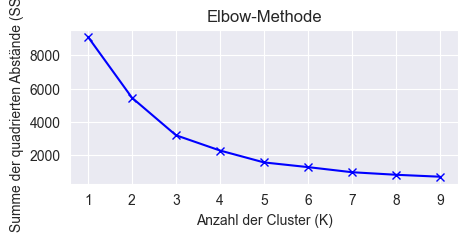

In [198]:
createElbow(df_basketball_football, 5, 2)

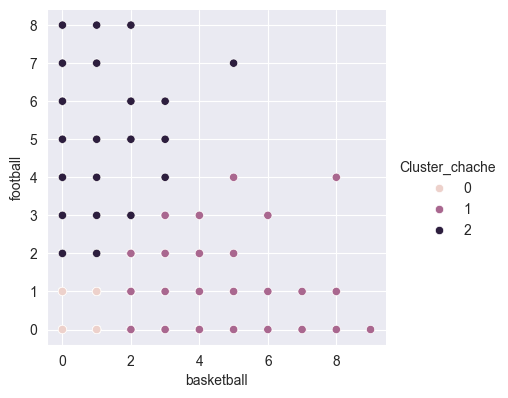

In [199]:
createPairPlot(df_basketball_football, 'basketball', 'football', 4, 3)

### Age / Basketball

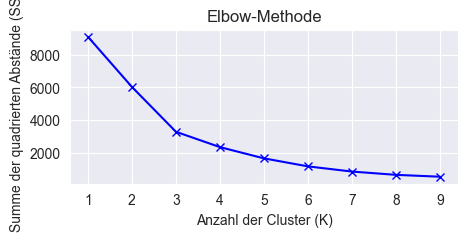

In [200]:
createElbow(df_age_basketball, 5, 2)

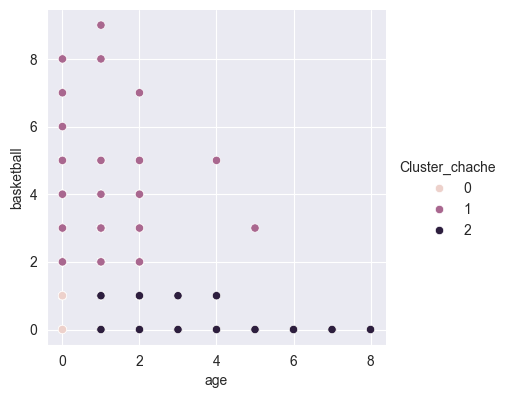

In [201]:
createPairPlot(df_age_basketball, 'age', 'basketball', 4, 3)

### Age / Football

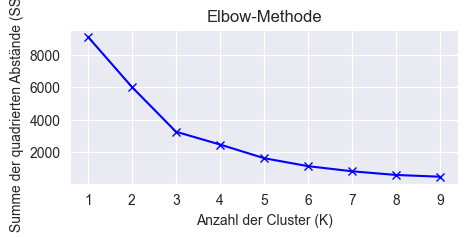

In [202]:
createElbow(df_age_football, 5, 2)

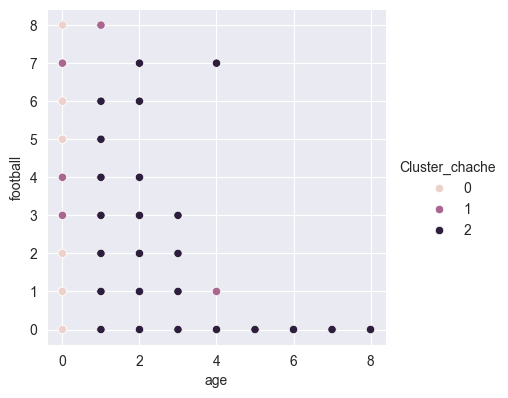

In [204]:
createPairPlot(df_age_basketball, 'age', 'football', 4, 3)

### tests

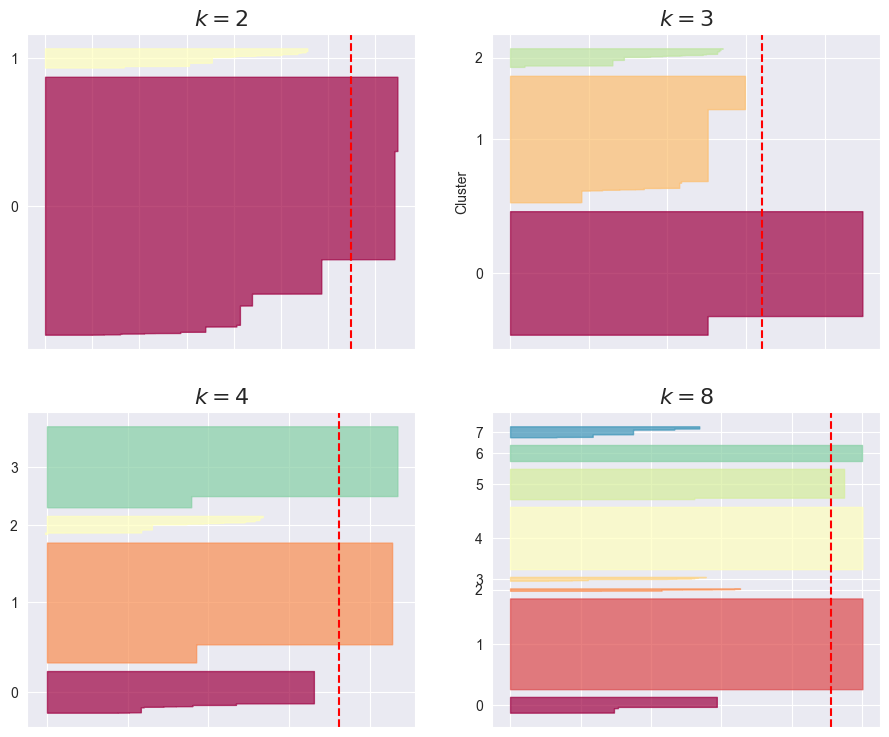

In [203]:
df_social['test1'] = df_social[['football', 'basketball', 'soccer', 'softball', 'volleyball', 'tennis', 'sports']].sum(axis=1)
df_social['test2'] = df_social[['sex', 'sexy', 'cute', 'kissed']].sum(axis=1)

df_test = scaler.fit_transform(df_social[['football', 'basketball']])
# Alter vs Basketball plotten
silhouette_diagram(df_age_football, (2, 3, 4, 8))